In [1]:
import pandas as pd
import nltk
import gzip
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import random 
from matplotlib import pyplot
from pylab import rcParams

rcParams['figure.figsize'] = 15, 10
np.random.seed(42)

# Introduction

In this notebook, we will explore opinion mining and sentiment analysis through the use of natural language processing. Our dataset consists of reviews of electronic products scraped form Amazon and available here: http://jmcauley.ucsd.edu/data/amazon/

The objective of this analysis is to use the reviews of a product to extract meaningful concepts about it. Such concepts can then be used to help the user make faster and more informed decisions when shopping. The extracted concepts consist of pairs of words that describe a property of the product. Those pairs are either of the type adjective-noun or adverb-past participle.

For example:

* Adjective - Nouns: (good, quality) (low, price) (best, deal)
* Adverb - Past Participle pairs such as (well, made) (poorly, assembled)

The concepts can then be categorised into positive and negative opinions. 

## Table of Contents

<ol>
<li> <a href="#Data-Overview">Data Overview</a>
    <ol>
        <li><a href="#Reading-the-data">Reading the data</a></li>
        <li><a href="#Data-Overview">Formats</a></li>
        <li><a href="#Missing-values">Missing values</a></li>
        <li><a href="#Distributions">Distributions</a></li>
    </ol>
</li>
<p></p>
<li> <a href="#Characteristics-Extraction">Characteristics Extraction</a>
<ol>
        <li><a href="#Data-Overview">Data Overview</a></li>
    </ol>
</li>
<p></p>
<li><a href="#Sentiment-Analysis">Sentiment Analysis</a></li>
<p></p>
        <li><a href="#Sentiment-Analysis,-revisited">Sentiment Analysis, revisited</a></li>
<p></p>
<li><a href="#Application">Applications</a>
<ol>
        <li><a href="#Brand-Rating">Brand Rating</a></li>
    </ol>
</li>
</ol>

# Reading the data 
**<a href="#Table-of-Contents">Back to table of contents</a>**

For this intermediate milestone we will be using the following datasets:

1. Sample of electronic review (1,689,188 reviews)
2. Full dataset metadata

#### 1. Electronic reviews sample
Those easily fit in memory. Therefore, we can read the data line by line and store the result in a dataframe.
#### 2. Full dataset metadata
The metadata was downloaded from the cluster. It is not possible to load it in memory as when uncompressed it is more than 10GB in size. Since we care about electronic products for the moment, we read it line by line and only store the entries whose category is related to electronics. This results in a much smaller file of approx 500Mo (uncompressed) which can hold in memory.

## Scalability
We argue that processing the data locally will scale reasonably well to the rest of the Electronic reviews as our pipeline is applied separately for each product. That is, we only need to hold the reviews of one product as well as its metadata in memory at any given time.

## Code

### Reading the data file
To open the data file we reuse the python code given by the author of the dataset. (See http://jmcauley.ucsd.edu/data/amazon/)

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
        
def parseUncompressed(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    """
    Reads a data file and use it the build a DataFrame
    """
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Reading the metadata file

In [3]:
def metadata_for_category(path, category):
    """
    Reads the metadata file and extract only metadata for the given category
    path: The path to the metadata file
    category: The product category for which to extract the metadata
    
    Returns a DataFrame holding the metadata
    """
    i = 0
    df = {}
    for d in parseUncompressed(path):
        if 'categories' in d:
            for categories_list in d['categories']:
                if categories_list[0] == category:
                    df[i] = d
                    i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Loading and storing intermediate results
DataFrames' `to_pickle` and `read_pickle` are used to respectively save and load serialized version of our intermediate results. We use it for example to store only the Electronics metadata:

In [ ]:
df = metadata_for_category('data/metadata.json', 'Electronics')
df.to_pickle('data/metadata_electronics_serialized.pickle')

In [ ]:
df = getDF('data/reviews_Electronics_5.json.gz')
df.to_pickle('data/electronics_serialized.pickle')

# Data Overview

In [5]:
df_elec = pd.read_pickle('data/electronics_serialized.pickle')

In [6]:
df_meta = pd.read_pickle('data/metadata_electronics_serialized.pickle')

### Formats

We will now discribe the different formats:

In [7]:
df_elec['reviewTime']  = pd.to_datetime(df_elec['reviewTime'],format='%m %d, %Y')
df_elec.dtypes

summary                   object
reviewerName              object
reviewTime        datetime64[ns]
overall                  float64
asin                      object
helpful                   object
unixReviewTime             int64
reviewerID                object
reviewText                object
dtype: object

* summary: The summary of the product
* reviewerName: The reviewer name
* reviewTime: The review time in the datetime type
* overall: The rating of the product from 1 to 5 included
* asin: The id of the product
* helpfull: The helpfulness of the comment. It is stored as an array; the first element is the number of positive votes the second element is the total number of votes for the comment.
* unixReviewTime: The review time in the unix format
* reviewerID: The reviewer id
* reviewText: The text of the review

In [8]:
df_meta = df_meta[pd.notnull(df_meta['brand'])]
df_meta.dtypes

title           object
description     object
imUrl           object
categories      object
asin            object
price          float64
salesRank       object
related         object
brand           object
dtype: object

* title: The name of the product
* description: The description of the product
* imUrl: The url of the image
* categories: The categories of the product, stored as an array
* asin: The id of the product
* price: The price of the product
* selesRank: The sales rank, stored as dictionary mapping the category to the rank
* related: The related products, stored as dictionary mapping a tag (also_bought, bought_together,...) to the asin
* brand: The name of the brand

### Missing values

To plot the data, we discarded every null entries in price and reviewLength.

In [9]:
df_merged = df_meta.merge(df_elec, left_on='asin', right_on='asin', how='inner')
df_merged['reviewLength'] = df_merged['reviewText'].str.len()

df_plot = df_merged.copy()
df_plot = df_plot[pd.notnull(df_plot['price'])]
df_plot = df_plot[pd.notnull(df_plot['reviewLength'])]

### Distributions

We plotted the scatter matrix of the price, the review length and the overall score, to have some insight on the global distribution of the data:

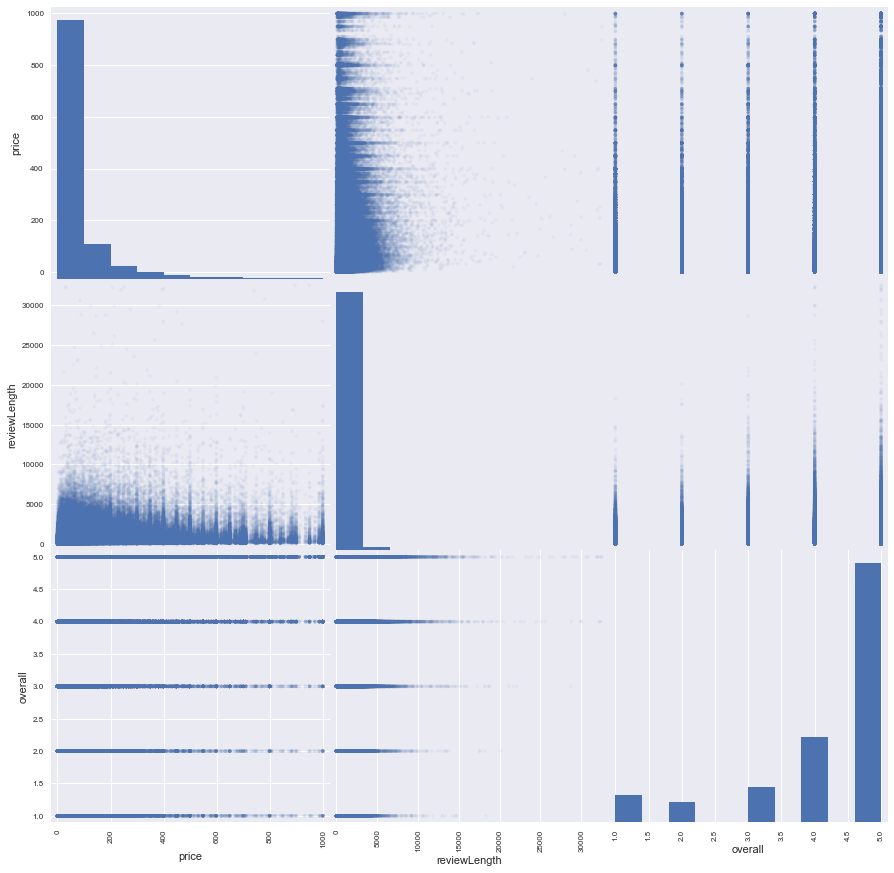

In [10]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_plot[['price','reviewLength','overall']], alpha=0.05, figsize=(15, 15), diagonal='hist')
plt.show()

We also plotted the price over the review length to see in more details the data. We can directly see that there is a lot of noise (as expected). We also see that most of the mass is concentrated in a rather small interval; indeed the median of the price is 28.5 and the median of the text length is 312.

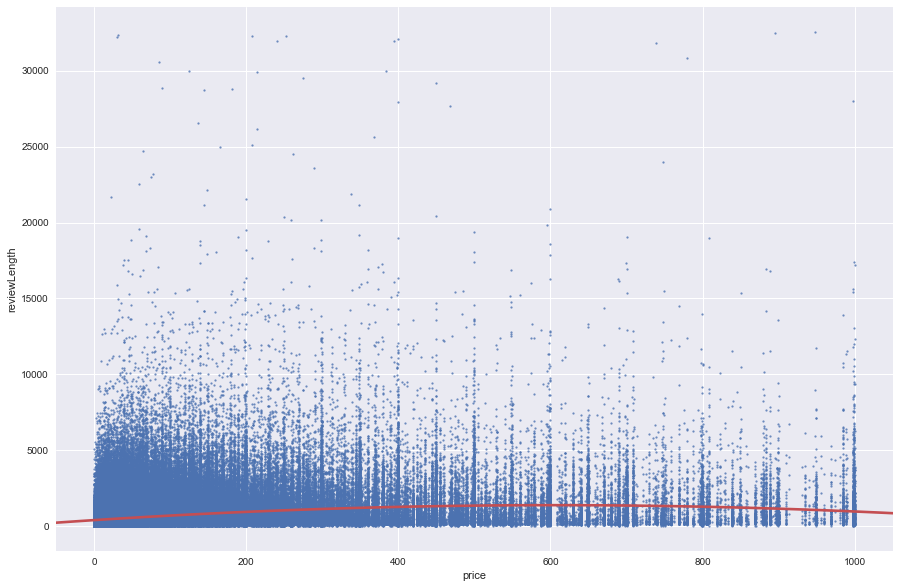

In [11]:
sns.regplot(y='reviewLength', x='price', data=df_plot,scatter_kws={'s':5},line_kws={'color':'r'},order=2)
plt.show()

We also plotted the distributions of the reviewLength over the overall. We can see that the extremes are less present in the data. Indeed, the review length is smaller for good reviews, this can be explained by the fact those reviews are synthetic: “Well made”, “Good Product”. The reviews that have a bad score (2) tend to be larger, as the critic can be big.

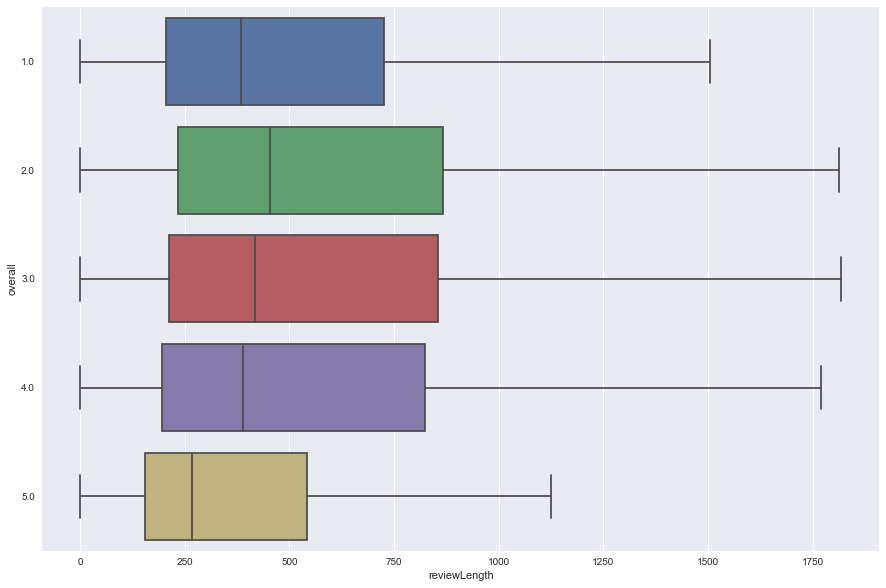

In [12]:
sns.boxplot(y='overall', x='reviewLength', data=df_plot, orient='h', showfliers=False)
plt.show()

Finally, we interested ourselves to the distribution of the price and the review length by plotting their density and the box plot.

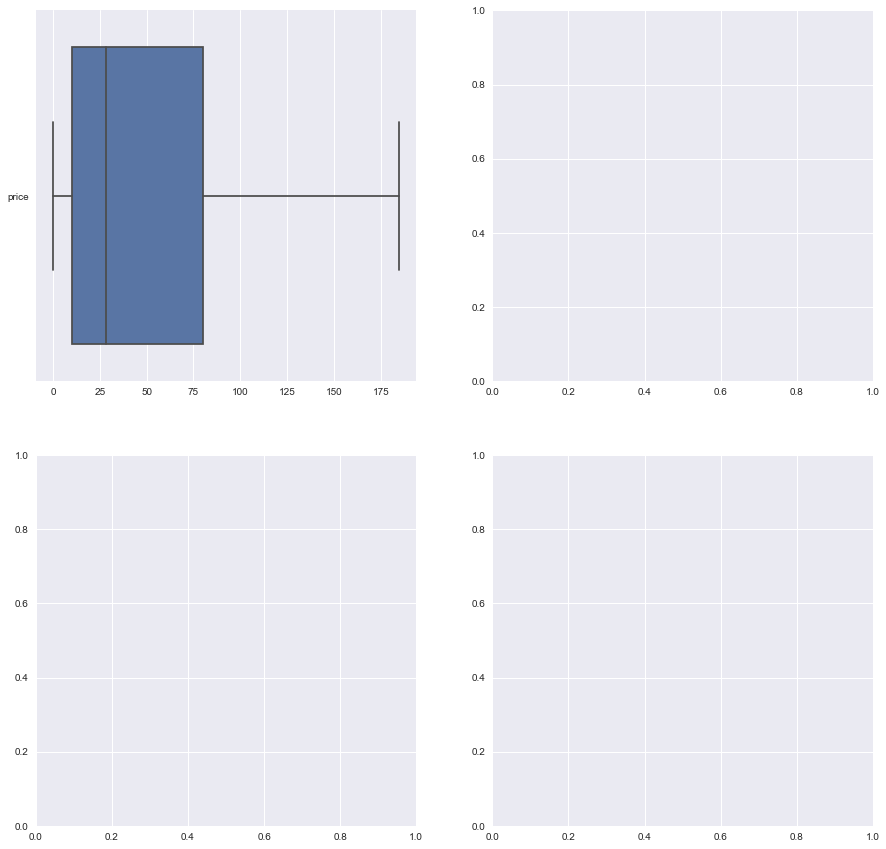

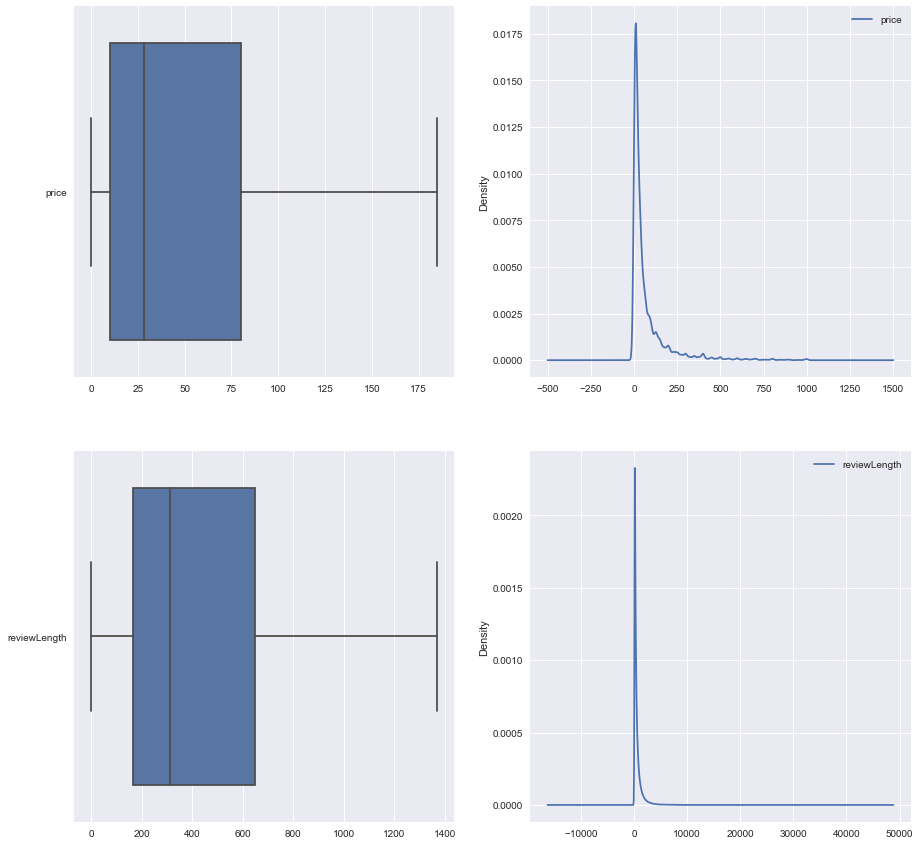

In [14]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.boxplot(data= df_plot[['price']],orient='h', showfliers=False,ax=axes[0,0])
df_plot[['price']].plot.kde(ax=axes[0,1])
sns.boxplot(data= df_plot[['reviewLength']],orient='h', showfliers=False,ax=axes[1,0])
df_plot[['reviewLength']].plot.kde(ax=axes[1,1])

plt.show()

We tried to fit a specific distribution; the exponential distribution to the data provided. We see that if we pick lambda = 65, we get a close approximation to the result.

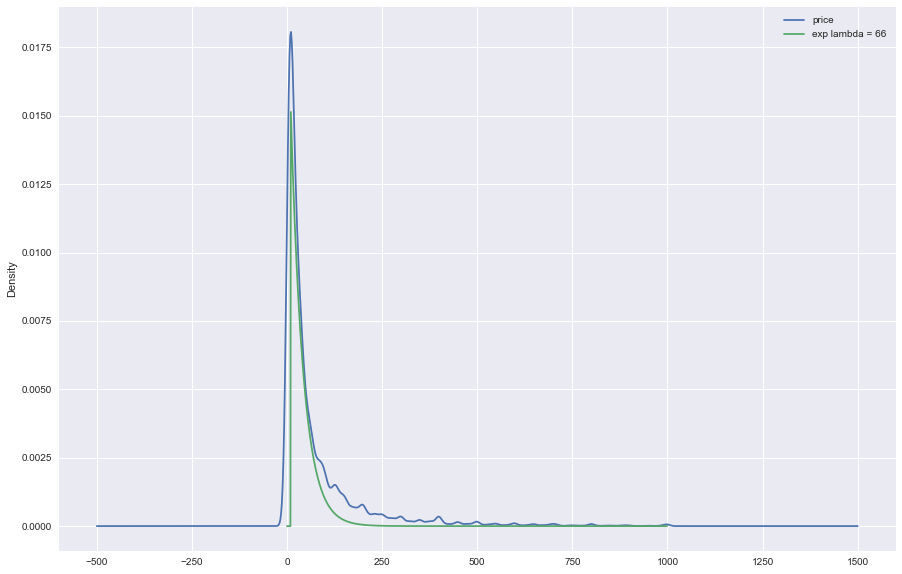

In [15]:
from scipy.stats import expon
import scipy.stats

d = df_plot[['price']]
ax = d.plot.kde()
x = ax.get_children()[0]._x
y = ax.get_children()[0]._y

scale = 66
loc = -480

pdf_fitted = expon.pdf(x - loc, scale=scale)
plt.plot(pdf_fitted,label= ('exp lambda = ' + str(scale)))
plt.legend(loc='best')
plt.show()

We tried to fit a specific distribution; the pareto distribution to the data provided. We see that if we pick b = 1, we get a close approximation to the result up to a multiplicative constant.

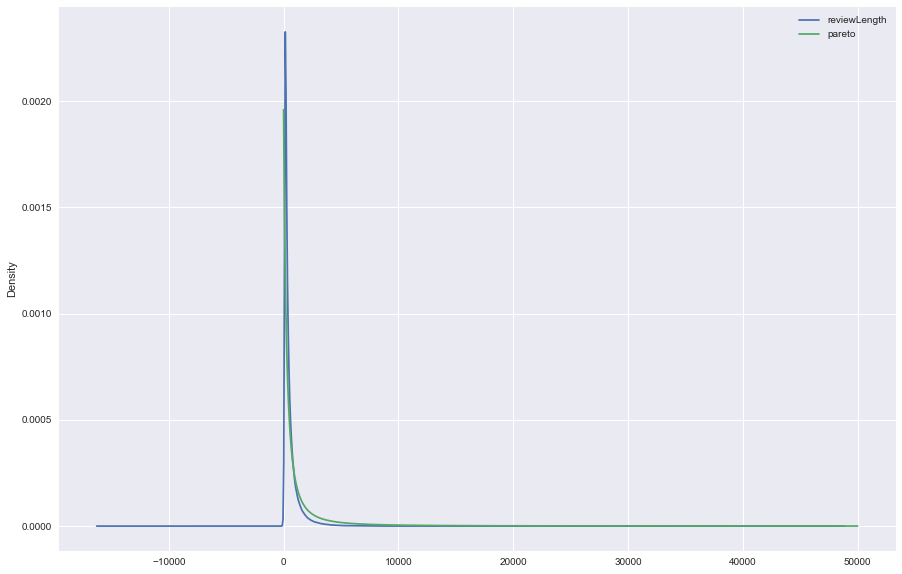

In [16]:
from scipy.stats import pareto
import scipy.stats

d = df_plot[['reviewLength']]
ax = d.plot.kde()

b = 1
x = np.linspace(pareto.ppf(0.01, b),pareto.ppf(0.99, b), 50000)
pdf_fitted = scipy.stats.pareto.pdf(x,b = b)/500
plt.plot(pdf_fitted,label= 'pareto')
plt.legend(loc='best')
plt.show()

### Correlations

We computed the correlation between the price, reviewLength, and the overall. We can see that the overall doesn't seem to be a lot correlated between the price and the review length. But more interestingly there seem to be some correlation between the price and the review lenght.

In [17]:
df_merged[['price','reviewLength','overall']].corr()

,price,reviewLength,overall
price,1.000000,0.249120,0.025969
reviewLength,0.249120,1.000000,-0.076393
overall,0.025969,-0.076393,1.000000


# Characteristics Extraction
**<a href="#Table-of-Contents">Back to table of contents</a>**

One simple and effective way of extracting opinions and product characteristics from review is to find adjective-nouns pairs that happen several times for a given product. Such pairs of words are also called collocations. Collocations are tuples of words that happen more frequently than one would expect if the words were distributed randomly in the text.

To find collocations, we use the [Natual Language Tool Kit (NLTK)](http://www.nltk.org/) package for Python. NLTK also provides an interface for the [WordNet](https://wordnet.princeton.edu/) lexical database.

WordNet can be used to find lexical relations between words. It is also capable of returning a part-of-speech (POS) tags for any given word. The nomenclature chosen for those tags is the open from the [Penn Treebank Project](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf). The tags used by our pipeline are the following:

Every tag starting with *JJ*: 
* JJ -	Adjective
* JJR -	Adjective, comparative
* JJS -	Adjective, superlative 

Every tag starting with *RB*:
* RB -	Adverb
* RBR - Adverb, comparative
* RBS - Adverb, superlative 
* VBN -	Verb, past participle 

Every tag starting with *NN*:
* NN -	Noun, singular or mass
* NNS -	Noun, plural
* NNP -	Proper noun, singular
* NNPS - Proper noun, plural 

Every tag starting with *VB*
* VB -	Verb, base form
* VBD -	Verb, past tense
* VBG -	Verb, gerund or present participle
* VBN -	Verb, past participle
* VBP -	Verb, non-3rd person singular present
* VBZ -	Verb, 3rd person singular present 

As explained in the introduction, we will extract pairs consisting of Adjective-Nouns (like "good quality"), Adverb - Past Participle (like "well made") and verb-adverb (like "works well"). 

In [20]:
def filterTags(w1,w2):
    """
    w1: First tagged word
    w2: Second tagged word
    
    Returns true if the bigram collocation is of type adjective-noun, adverb-past participle or verb-adverb
    """
    _, tag1 = nltk.pos_tag(nltk.word_tokenize(w1))[0]
    _, tag2 = nltk.pos_tag(nltk.word_tokenize(w2))[0]
    
    return (tag1.startswith('JJ') and tag2.startswith('NN')) or \
            (tag1.startswith('RB') and tag2.startswith('VBN')) or \
            (tag1.startswith('VB') and tag2=="JJ")

def getCollocations(text):
    """
    text: The concatenation of all the review for a given product
    
    Returns the collocations of words larger 
    """
    ignored_words = nltk.corpus.stopwords.words('english')
    
    tokens = nltk.word_tokenize(text)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    
    finder = nltk.BigramCollocationFinder.from_words(tokens)
    
    # Ignore bigram that are infrequent
    finder.apply_freq_filter(3)
    
    # Retrieves the 10 most common bigrams
    res = finder.nbest(bigram_measures.pmi, 10)
        
    res = [x for x in res if filterTags(x[0],x[1])]

    if(len(res) > 0):
        return res
    else:
        return np.nan

The products are grouped together and their respective reviews concatenated. The result of the concatenation is then fed to the collocation finder. 

In [25]:
from timeit import default_timer as timer

strt = timer()

df_product = df_elec.groupby(["asin"])['reviewText'].agg(lambda x:''.join(set(x.str.lower()))).reset_index()
df_product = df_product.sample(n=1000, random_state=1)

df_product["reviewText"] = df_product["reviewText"].apply(lambda x: getCollocations(x))
end = timer()
print(end - start)  

467.24852523573315


You can see the results below:

In [26]:
df_product = df_product.dropna(how = 'any')
df_product.head(20)

,asin,reviewText
59102,B00CZ0T5NG,"[(high, performance)]"
54891,B009YP274O,"[(own, voice)]"
35474,B004FLL572,"[(good, quality)]"
8429,B000EWI8IK,"[(ultra, ii)]"
43737,B005SCYZGA,"[(large, screen)]"
36523,B004JWA70I,"[(several, times)]"
13951,B000WTX7GI,"[(new, unit)]"
30338,B003M349VS,"[(heavy, duty), (hot, shoe)]"
5943,B0007RV3IE,"[(third, party), (free, shipping), (negative, ..."
26000,B002WOBBVO,"[(vertical, zipper), (many, backpacks)]"


We see that the characteristics extracted this way are already quite interesting. We see that some products were described several time as beig of "high quality" or "well made". However, we also note that a lot of bigram found do not actually correspond to product characteristics. This happens for example when the users write compound words such as "hard drive". Since this pair of words happen quite often in review for hard drives, our pipeline mistakenly detects it as an interesting collocation.

## Filtering the results further

We propose the following simple solution to filter out words: *If the bigram can be found in an english dictionnary, then it is not an interesting collocation.*

This will for example filter out results such as "hard drive" or "optical mouse".

However, findind a list of modern english words is not an easy task. Almost every dataset that can be found on the internet does not include nouns relevant for our work (such as hard drive or optical mouse). There are some online APIs such as [Oxford Dictionnary API](https://developer.oxforddictionaries.com/) or [Words API](https://www.wordsapi.com/) which return very rich results but they are priced prohibitively high, in the hundreds of dollars for the use we would make of them.

But here comes Wikipedia to the rescue, or more precisely, Wiktionnary. Wiktionnary is a free to use and open online dictionnary with over five millions english words. The best part is that it contains all the words we are looking for and it can be [downloaded](https://dumps.wikimedia.org/enwiktionary/) in its entirety (just like Wikipedia). We selected the subset consisting only of the title of the wiktionnary pages, as they are named according the word for which they provide a definition. 

Because we only need compound words, we will be able to greatly reduce the size of the wiktionary dataset:

In [27]:
wiktionnary = pd.DataFrame.from_csv('data/enwiktionary-latest-all-titles', sep='\t')

# Keep only compound words, spaces are represented using underscores
wiktionnary = wiktionnary[wiktionnary.page_title.str.contains('_', na=False)]

# Remove garbage pages entered by the user by keeping only alphanumeric titles
wiktionnary_filtered = wiktionnary[wiktionnary.page_title.str.contains("^\w+$", na=False, regex=True)]

compound_words = wiktionnary_filtered.page_title
compound_words = compound_words.str.lower()
compound_words.head()
print(len(compound_words))

compound_words.to_pickle("data/filtered_compound_words.pickle.gz", compression='gzip')

FileNotFoundError: File b'data/enwiktionary-latest-all-titles' does not exist

We reduced the size of our dictionnary down to ~376k entries. We can now use this dictionnary to filter out uninteresting collocations.

In [ ]:
compound_dictionnary = pd.read_pickle("data/filtered_compound_words.pickle.gz")

def is_compound_word(word):
    return word in compound_dictionnary.values

def filter_bigram_list(tuple_list):
    l = [tup for tup in tuple_list if not is_compound_word(tup[0]+'_'+tup[1]]
    return l if l else np.nan

In [ ]:
df_product_filtered = df_product.copy()

# Filter out bigrams that corresponds to words in dictionnary
df_product_filtered.reviewText = df_product_filtered.reviewText.apply(filter_bigram_list)
df_product_filtered = df_product_filtered[df_product_filtered.reviewText.notnull()]

And finally display our results:

In [ ]:
df_product_filtered.head(35)

While not perfect we see that we already get interesting results.

# Sentiment Analysis
**<a href="#Table-of-Contents">Back to table of contents</a>**

We now want to be able to categorise the opinions we extracted in the previous part of this notebook. One way of doing this is to use [SentiWordNet](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf). SentiWordNet is a lexical resource for performing sentiment analysis on texts. It is base on WordNet. Fortunately, the NLTK package for python provides an interface for using SentiWordNet.

We implemented a class on top of NLTK's support for SentiWordNet in order to provide a convenient interface to tokenize and classify opinions. The implementation is encapsulated in the SentimentAnalyzer class in the [SentimentAnalyser.py](SentimentAnalyser.py) file.

### Classifying opinions

SentiWordNet provides a positivity score for each word which can then be used to asses the positivity of a sentence of for our pipeline, a pair of words. A score above than 0 denotes a positive connotation of the word while a score below 0 denotes a negative connotation. See the following examples: 

In [ ]:
from SentimentAnalyser import *

In [ ]:
sentimentAnalyzer = SentimentAnalyser()

examples = ['Hello world', 'The screen is poorly assembled', 'Worst purchase I\'ve done', 'Excellent quality', 'Best deal']

for sentence in examples:
    print("{} : {}".format(sentence, sentimentAnalyzer.sentiment_score_for_raw_sentence(sentence)))

Using those score, we would then classify the second and the third as being negative ans the fourth and fifth as being positive. While looking very promising this approach has a major flaw for our application:

In [ ]:
examples = ['Cheap quality', 'Low price']

for sentence in examples:
    print("{} : {}".format(sentence, sentimentAnalyzer.sentiment_score_for_raw_sentence(sentence)))

It is not able to classify correctly opinions which are positive but writte with negatively connoted words and vice versa. This is why we propose an alternative approach.

# Sentiment Analysis, revisited
**<a href="#Table-of-Contents">Back to table of contents</a>**

As we didn't get as much good result as we wished, we created a machine learning model, that will be able to predict the sentiment of a word or two. We setted the negative sentiment to -1 and the positive to 1. We only kept the text that are smaller that 100 for the train set, to have for now a quickly trained model (but still relatively good for our task). We divided in the train the dataset into the one with an overall smaller to three (bad sentiment -1) and the one with an overall equal to five (good sentiment 1). We used a multilayer perceptron classifier to classify our data.

In [ ]:
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.base import TransformerMixin
np.random.seed(42)

# Keep only the word with a length lower than 100
df_ML = df_elec[(df_elec["reviewText"].str.len()<100)].copy()
# Map every overall to a score {-1,1}
df_ML['score'] = df_elec["overall"].apply(lambda x : -1 if x < 3 else 1)

# Equilibrate the train data between the positive and negative sentiment
df_0 = (df_ML[df_ML["score"] == -1])
df_1 = (df_ML[df_ML["score"] == 1])

if df_0.shape[0] > df_1.shape[0]:
    df_0 = df_0.sample(df_1.shape[0])
else:
    df_1 = df_1.sample(df_0.shape[0])
    
sentiment_data = pd.concat([df_0, df_1])
X = sentiment_data["reviewText"]
y = sentiment_data["score"]

# Split the data between test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

print(X_train.shape)
print(X_test.shape)

To create our model, we will define a pipeline. This pipeline, will first preprocess the data by taking takign the text to lower case. Then, we will vectorize our data by counting the bigrams and words present in the text, we will assign those as features for our classifier. Finally, we will used the data created for our MLP classifier.

Then, we train and test our data.

In [ ]:
# Define the pipeline used to create the model
bigram_clf = Pipeline([
    (
        'vectorizer', CountVectorizer(
            analyzer="word",
            ngram_range=(1, 2),
            tokenizer=word_tokenize, 
            preprocessor=lambda text: text.lower()
        )
    ),
    (
        'classifier', MLPClassifier(verbose = True)
    )
])

bigram_clf.fit(X_train, y_train)
bigram_clf.score(X_test, y_test)

We see that for some common entries, we get the result that we except:

In [ ]:
X = ["LOW PRICE","expensive","cheap","high quality","low quality","well made",'poorly made','good product']
y = [1,-1,-1,1,-1,1,-1,1]

print(bigram_clf.score(X,y))
print(bigram_clf.predict(X))

# Application

**<a href="#Table-of-Contents">Back to table of contents</a>**

We will now implement the score to each item using the model developped above. This will allow us to give a score to each brand based on the sentiment of the reviews of each of their product. 

We will take the number of occurences of the most commons bigrams and multiply them with their respective sentiment score {-1,1}, we will take the averaged sum of those score to get the overall score of the item.

In [ ]:
def isInDescriptionOrTitle(text,description,title):
    """Filter the characteristics that are present in the name or the description of the product. This will ensure that the
    words exctracted are only sentiment related characteristics and not some attribute of the object. This can be applied for
    the word 'hard drive'.
    """
    res = [] 
    for t in text:
        ((a,b),num) = t
        if (a + ' ' + b).lower() not in str(description).lower() and (a + ' ' + b).lower() not in str(title).lower():
            res.append(t)
    if len(res) > 0:
        return res
    else:
        return np.nan
    
def getScore(text):
    """Takes the different characteristics of a product. Return the score by taking the averaged sum of the sentiment scores 
    of each characteristics.
    """
    if len(text) == 0:
        return np.nan
    
    res = 0
    
    for t in text:
        ((a,b),num) = t
        res += bigram_clf.predict([a + ' ' + b]) * int(num)
    return res/len(text)

def getText(text):
    """Return the characteristics as a string separated by ' / ' for each characteristics.
    """
    res = []
    for t in text:
        ((a,b),num) = t
        res.append((a + ' ' + b).lower())
    return " / ".join(res)

def getUniqueWords(text):
    """Return the unique characteristics from the original string text as a string separated by ' / ' for each characteristics.
    """
    temp = text.split(' / ')
    res = set(temp)
    return " / ".join(res)

In [ ]:
df_final = df_product.merge(df_meta, left_on='asin', right_on='asin', how='inner')

# Filter the review text that are not characteristics
df_final['reviewText'] = df_final.apply(lambda x : isInDescriptionOrTitle(x['reviewText'],x['description'],x['title']), axis=1)
df_final = df_final[pd.notnull(df_final['reviewText'])]

# Extract the characteristics name
df_final["word"] = df_final.apply(lambda x : getText(x['reviewText']), axis=1)

# Compute the score
df_final['score'] = 0
df_final['score'] =  df_final.apply(lambda x : getScore(x["reviewText"]), axis=1)

In [ ]:
display(df_final)

# Brand Rating

**<a href="#Table-of-Contents">Back to table of contents</a>**

Finally to get the scores of the different brand we will sum each scores and take the mean to have respectively the score and the mean score.

In [ ]:
# Group by brand
f = {'score':['sum','mean'],'word': lambda x: ' / '.join(set(x))}
df_brand = df_final[['brand','word','score']].groupby(['brand']).agg(f)
df_brand.columns = df_brand.columns.droplevel()
df_brand = df_brand.reset_index()
df_brand = df_brand.rename(columns={'sum': 'score','mean': 'mean_score', '<lambda>': 'words'})

# Make sure to have unique characteristics and existing brand
df_brand['words'] = df_brand.apply(lambda x : getUniqueWords(x['words']), axis=1)
df_brand = df_brand[(df_brand['brand'] != 'Unknown') & (df_brand['brand'] != '')]

In [ ]:
display(df_brand.sort_values('score',ascending=False))

We plotted the different mean scores of the brands:

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,18))
sns.barplot(y="brand",x='mean_score', ax = ax,orient='h',data=df_brand.sort_values('mean_score',ascending=False),palette = sns.color_palette("BuGn_r", 1));
plt.show()